# Wizualizacja działania algorytmu

## Konfiguracja

### Zaproponowane narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points = points
        self.lines = lines


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points


# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=[Scene()], points=[], lines=[], json=None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines": [linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on=False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## import bibliotek

In [67]:
import random
import time

### Dodatkowe funkcje

In [3]:
def edgesToPoints(edges):
    points = []
    for e in edges:
        points.append(e.leftPoint)
        points.append(e.rightPoint)

    return points


def edgesToUIPoints(edges):
    points = []
    for e in edges:
        points.append([e.start.x, e.start.y])
        points.append([e.end.x, e.end.y])

    return points


def edgesToUILines(edges):
    lines = []
    for e in edges:
        lines.append([[e.start.x, e.start.y], [e.end.x, e.end.y]])
    return lines

def uiEdgesToUIPoints(lines):
    points = []
    for line in lines:
        points.extend(line)
    return points


def coefficients(p1, p2):
    a = (p1.y-p2.y) / (p1.x-p2.x)
    return (a, p1.y-a*p1.x)


def functionValue(seg, x):
    a, b = coefficients(seg.leftPoint, seg.rightPoint)
    return a*x + b

def functionValueWithCheck(seg, x):
    a, b = coefficients(seg.leftPoint, seg.rightPoint)
    val = a*x + b
    if min(seg.leftPoint.y, seg.rightPoint.y) <= val <= max(seg.rightPoint.y, seg.leftPoint.y):
        return val
    else:
        return seg.rightPoint.y 


## Moduł graficzny

In [9]:
class DagData:
    def __init__(self):
        self.lines = []
        self.points = []
        self.trapezoids = []


class Visualizer:
    def __init__(self, lines):
        self.lines = lines
        self.scenes = []
        self.line_color = 'green'
        self.point_color = 'blue'
        self.trapezoid_color = 'darkblue'
        if lines is not None:
            self.base_points = edgesToUIPoints(lines)
            self.addFigure(lines)

    def addFigure(self, lines):
        points = uiEdgesToUIPoints(lines)
        self.lines.extend(lines)
        self.scenes.append(Scene([PointsCollection(points, color=self.point_color)],
                     [LinesCollection(self.lines, color=self.line_color)]))

    def addDag(self, dag):
        dagData = DagData()
        self.traverseDag(dagData, dag.root)
        trLines = []
        for trapezoid in dagData.trapezoids:
            trLines.extend(trapezoid)
        self.scenes.append(Scene([PointsCollection(dagData.points, color=self.point_color)],
                     [LinesCollection(trLines, color=self.trapezoid_color),
                      LinesCollection(dagData.lines, color=self.line_color)]))

    def traverseDag(self, dagData: DagData, node):
        if node is None:
            return
        if node.type == "tnode":
            dagData.trapezoids.append(node.getDrawable())
            return
        elif node.type == "xnode":
            dagData.points.append(node.endPoint.toList())
            self.traverseDag(dagData, node.left)
            self.traverseDag(dagData, node.right)
        else:
            dagData.lines.append(node.lineSegment.toList())
            self.traverseDag(dagData, node.above)
            self.traverseDag(dagData, node.below)

    def addDagWithResult(self, dag, tr, point):
        dagData = DagData()
        self.traverseDag(dagData, dag.root)
        trLines = []
        for trapezoid in dagData.trapezoids:
            trLines.extend(trapezoid)
        self.scenes.append(Scene([PointsCollection(dagData.points, color=self.point_color),
                                  PointsCollection([point.toList()], color='red')],
                                 [LinesCollection(trLines, color=self.trapezoid_color),
                                  LinesCollection(dagData.lines, color=self.line_color),
                                  LinesCollection(tr.getDrawable(), color='magenta')]))

    def getScenes(self):
        return self.scenes

## Dodatkowe funkcje graficzne

In [11]:
from random import randint

def getLineSegments(plot):
    segments = plot.get_added_elements().lines[0].lines
    return segments

def getFigureSegments(plot):
    segments = plot.get_added_figure().lines[0].lines
    return segments


def getLineObjects(lines):
    return [Segment(Point(line[0][0], line[0][1]), Point(line[1][0], line[1][1])) for line in lines]

def getPoints(plot):
    seg = plot.get_added_elements().lines[0].lines
    points = []

    for l in seg:
        points.append(l[0])
        points.append(l[1])

    return points


def generateRandomLineSegments(n, min_x, max_x, min_y, max_y):
    segments = []
    s = set()

    while n > 0:
        x1 = randint(min_x, max_x)
        x2 = randint(min_x, max_x)

        y1 = randint(min_y, max_y)
        y2 = randint(min_y, max_y)

        if x1 == x2:
            continue

        if x1 in s or x2 in s:
            continue

        if x1 > x2:
            segments.append(((x2, y2), (x1, y1)))
        else:
            segments.append(((x1, y1), (x2, y2)))

        s.add(x1)
        s.add(x2)
        n -= 1

    return segments

## Użyte struktury

In [5]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.seen = False

    def toList(self):
        return [self.x, self.y]

    def __str__(self):
        return "(" + str(self.x) + "," + str(self.y) +  ")"


class Segment:
    def __init__(self, p, q):
        self.leftPoint = p
        self.rightPoint = q
        if q.x < p.x:
            self.leftPoint = q
            self.rightPoint = p

        if p.x != q.x:
            self.slope = (self.rightPoint.y - self.leftPoint.y) / (self.rightPoint.x - self.leftPoint.x)
            self.const = self.leftPoint.y - (self.slope * self.leftPoint.x)

    def isPointAbove(self, point):
        if point.y > (self.slope * point.x) + self.const:
            return True
        return False

    def getY(self, x):
        if self.leftPoint.x <= x <= self.rightPoint.x:
            return (self.slope * x) + self.const
        return None

    def toList(self):
        return [(self.leftPoint.x, self.leftPoint.y), (self.rightPoint.x, self.rightPoint.y)]

    def __str__(self):
        return str(self.leftPoint) + ", " + str(self.rightPoint)


class XNode:
    def __init__(self, point, left=None, right=None):
        self.isLeaf = False
        self.type = 'xnode'
        self.setLeft(left)
        self.setRight(right)
        self.endPoint = point
        self.endPoint.seen = True

    def setLeft(self, node):
        self.left = node
        if node is None:
            return
        if node.isLeaf and self not in node.parents:
            node.parents.append(self)

    def setRight(self, node):
        self.right = node
        if node is None:
            return
        if node.isLeaf and self not in node.parents:
            node.parents.append(self)

    def getName(self):
        return self.endPoint.name


class YNode:
    def __init__(self, segment, above=None, below=None):
        self.isLeaf = False
        self.type = 'ynode'
        self.setAbove(above)
        self.setBelow(below)
        self.lineSegment = segment

    def setAbove(self, node):
        self.above = node
        if node is None:
            return
        if node.isLeaf and self not in node.parents:
            node.parents.append(self)

    def setBelow(self, node):
        self.below = node
        if node is None:
            return
        if node.isLeaf and self not in node.parents:
            node.parents.append(self)

    def getName(self):
        return self.lineSegment.name


class TrapezoidNode:
    def __init__(self, topSegment = None, bottomSegment = None, leftPoint = None, rightPoint = None):
        self.isLeaf = True
        self.type = 'tnode'
        self.topSegment = topSegment
        self.bottomSegment = bottomSegment
        self.leftPoint = leftPoint
        self.rightPoint = rightPoint
        self.parents = []
        self.name = None

    def containsSegment(self, segment):
        if self.containsPoint(segment.leftPoint) or self.containsPoint(segment.rightPoint):
            return True
        resY = segment.getY(self.leftPoint.x)
        if resY is not None:
            leftIntersection = Point(self.leftPoint.x, resY)
            if self.containsPoint(leftIntersection):
                return True
        return False

    def containsPoint(self, point):
        if self.leftPoint.x <= point.x <= self.rightPoint.x:
            return self.bottomSegment.isPointAbove(point) and not self.topSegment.isPointAbove(point)
        return False

    def replacePositionWith(self, tzMap, node):
        if not self.parents:
            tzMap.updateRoot(node)
            return
        for parent in self.parents:
            if parent.type == 'xnode':
                if parent.left == self:
                    parent.setLeft(node)
                else:
                    parent.setRight(node)
            else:
                if parent.above == self:
                    parent.setAbove(node)
                else:
                    parent.setBelow(node)

    def getName(self):
        return self.name

    def toLines(self):
        lines = [self.topSegment.toList(), self.bottomSegment.toList()]
        leftVerticalLine = Segment(self.topSegment.leftPoint, self.bottomSegment.leftPoint)
        if self.rightPoint is not None:
            rightVerticalLine = Segment(self.topSegment.rightPoint, self.bottomSegment.rightPoint)
            lines.append(rightVerticalLine.toList())
        lines.append(leftVerticalLine.toList())
        return lines

    def getDrawable(self):
        newTr = createTrapezoid(self.topSegment, self.bottomSegment, self.leftPoint, self.rightPoint)
        return newTr.toLines()


def createTrapezoid(topSegment, bottomSegment, leftPoint, rightPoint):
    newTr = TrapezoidNode()

    leftUpperPoint = Point(leftPoint.x, functionValue(topSegment, leftPoint.x))
    leftLowerPoint = Point(leftPoint.x, functionValue(bottomSegment, leftPoint.x))
    rightUpperPoint = Point(rightPoint.x, functionValue(topSegment, rightPoint.x))
    rightLowerPoint = Point(rightPoint.x, functionValue(bottomSegment, rightPoint.x))

    newTr.topSegment = Segment(leftUpperPoint, rightUpperPoint)
    newTr.bottomSegment = Segment(leftLowerPoint, rightLowerPoint)
    newTr.leftPoint = leftPoint
    newTr.rightPoint = rightPoint

    return newTr


class Dag:
    def __init__(self, root):
        self.root = root

    def updateRoot(self, root):
        self.root = root


## Główny algorytm

In [28]:
import random
"""
    Segment intersects only one
    trapezoid.
"""


def simpleCase(dag, trapezoid, segment, visualizer = None):
    leftTrapezoid = TrapezoidNode(trapezoid.topSegment, trapezoid.bottomSegment, trapezoid.leftPoint, segment.leftPoint)
    topTrapezoid = TrapezoidNode(trapezoid.topSegment, segment, segment.leftPoint, segment.rightPoint)
    bottomTrapezoid = TrapezoidNode(segment, trapezoid.bottomSegment, segment.leftPoint, segment.rightPoint)
    rightTrapezoid = TrapezoidNode(trapezoid.topSegment, trapezoid.bottomSegment, segment.rightPoint, trapezoid.rightPoint)

    segNode = YNode(segment, topTrapezoid, bottomTrapezoid)
    q = XNode(segment.rightPoint, segNode, rightTrapezoid)
    p = XNode(segment.leftPoint, leftTrapezoid, q)
    trapezoid.replacePositionWith(dag, p)

    if visualizer is not None:
        visualizer.addDag(dag)


"""
    Segment intersects multiple
    trapezoids.
"""


def hardCase(dag, intersectedTrapezoids, segment, visualizer):

    upperMidTrapezoid = None
    lowerMidTrapezoid = None
    mergeUpper = False

    for trapezoid in intersectedTrapezoids:

        if trapezoid.containsPoint(segment.leftPoint):
            # case where the left endpoint of the new segment lies in the trapezoid
            leftTrapezoid = TrapezoidNode(trapezoid.topSegment, trapezoid.bottomSegment, trapezoid.leftPoint, segment.leftPoint)
            if segment.isPointAbove(trapezoid.rightPoint):
                upperMidTrapezoid = TrapezoidNode(trapezoid.topSegment, segment, segment.leftPoint, trapezoid.rightPoint)
                lowerMidTrapezoid = TrapezoidNode(segment, trapezoid.bottomSegment, segment.leftPoint, None)
                mergeUpper = False
            else:
                upperMidTrapezoid = TrapezoidNode(trapezoid.topSegment, segment, segment.leftPoint, None)
                lowerMidTrapezoid = TrapezoidNode(segment, trapezoid.bottomSegment, segment.leftPoint, trapezoid.rightPoint)
                mergeUpper = True

            if segment.leftPoint.seen:
                continue
            segNode = YNode(segment, upperMidTrapezoid, lowerMidTrapezoid)
            p = XNode(segment.leftPoint, leftTrapezoid, segNode)
            trapezoid.replacePositionWith(dag, p)

        elif trapezoid.containsPoint(segment.rightPoint):
            # case where the right endpoint of the new segment lies in the trapezoid
            rightTrapezoid = TrapezoidNode(trapezoid.topSegment, trapezoid.bottomSegment, segment.rightPoint, trapezoid.rightPoint)
            if mergeUpper:
                upperMidTrapezoid.rightPoint = segment.rightPoint
                lowerMidTrapezoid = TrapezoidNode(segment, trapezoid.bottomSegment, trapezoid.leftPoint, segment.rightPoint)
            else:
                upperMidTrapezoid = TrapezoidNode(trapezoid.topSegment, segment, trapezoid.leftPoint, segment.rightPoint)
                lowerMidTrapezoid.rightPoint = segment.rightPoint
            if segment.rightPoint.seen:
                continue
            segNode = YNode(segment, upperMidTrapezoid, lowerMidTrapezoid)
            q = XNode(segment.rightPoint, segNode, rightTrapezoid)
            trapezoid.replacePositionWith(dag, q)

        else:
            # case where the no endpoint of the new segment lies in the trapezoid
            if mergeUpper:
                lowerMidTrapezoid = TrapezoidNode(segment, trapezoid.bottomSegment, trapezoid.leftPoint, None)
            else:
                upperMidTrapezoid = TrapezoidNode(trapezoid.topSegment, segment, trapezoid.leftPoint, None)


            if segment.isPointAbove(trapezoid.rightPoint):
                upperMidTrapezoid.rightPoint = trapezoid.rightPoint
                mergeUpper = False
            else:
                lowerMidTrapezoid.rightPoint = trapezoid.rightPoint
                mergeUpper = True

            segNode = YNode(segment, upperMidTrapezoid, lowerMidTrapezoid)
            trapezoid.replacePositionWith(dag, segNode)

    if visualizer is not None:
        visualizer.addDag(dag)


def findIntersectedTrapezoids(node, segment, intersectedTrapezoids):
    if node.isLeaf:
        if node.containsSegment(segment):
            if node not in intersectedTrapezoids:
                intersectedTrapezoids.append(node)

    elif node.type == 'xnode':
        if segment.leftPoint.x >= node.endPoint.x:
            findIntersectedTrapezoids(node.right, segment, intersectedTrapezoids)
        else:
            findIntersectedTrapezoids(node.left, segment, intersectedTrapezoids)
            if segment.rightPoint.x >= node.endPoint.x:
                findIntersectedTrapezoids(node.right, segment, intersectedTrapezoids)

    else:
        ##if node.lineSegment.isPointAbove(segment.leftPoint):
        findIntersectedTrapezoids(node.above, segment, intersectedTrapezoids)
        ##else:
        findIntersectedTrapezoids(node.below, segment, intersectedTrapezoids)



def createBoundingBox():
    s = 2
    left = Point(-0.05*s,  0.05*s)
    right = Point(0.05*s,  0.05*s)
    topEdge = Segment(Point(-0.05*s, 0.05*s), Point(0.05*s, 0.05*s))
    bottomEdge = Segment(Point(-0.05*s, -0.05*s), Point(0.05*s, -0.05*s))
    return TrapezoidNode(topEdge, bottomEdge, left, right)


def findArea(node, point):
    if node.isLeaf:
        if node.containsPoint(point):
            return node
        else:
            return None

    elif node.type == 'xnode':
        if point.x >= node.endPoint.x:
            return findArea(node.right, point)
        else:
            return findArea(node.left, point)
    else:
        tr1 = findArea(node.above, point)
        if tr1 is not None:
            return tr1
        tr2 = findArea(node.below, point)
        return tr2


def buildDag(lineSegments, visualizer = None):
    dag = Dag(createBoundingBox())
    random.shuffle(lineSegments)
    for segment in lineSegments:
        intersectedTrapezoids = []
        findIntersectedTrapezoids(dag.root, segment, intersectedTrapezoids)
        #print(len(intersectedTrapezoids))
        if len(intersectedTrapezoids) == 1:
            simpleCase(dag, intersectedTrapezoids[0], segment, visualizer)
        else:
            hardCase(dag, intersectedTrapezoids, segment, visualizer)

    return dag



## Rysowanie przykładowych zbiorów

<IPython.core.display.Javascript object>


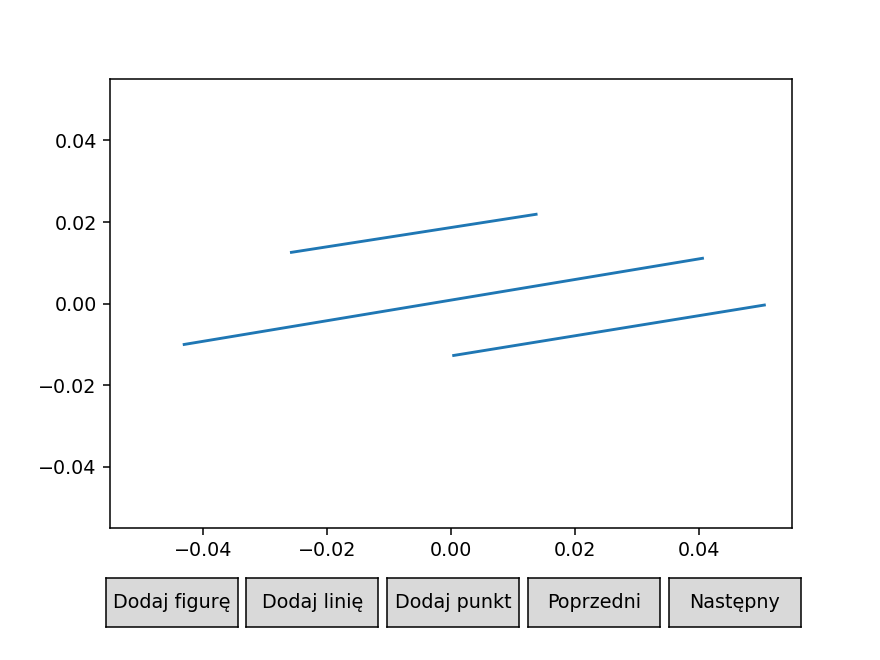

In [41]:
%matplotlib notebook

visualizer = Visualizer([])
plot1 = Plot()
plot1.draw()


In [64]:
lines1 = getLineObjects(getLineSegments(plot1))
print(lines1)

[<structures.Segment object at 0x0000023B60D179D0>, <structures.Segment object at 0x0000023B60D17AF0>, <structures.Segment object at 0x0000023B60D17BE0>]


<IPython.core.display.Javascript object>


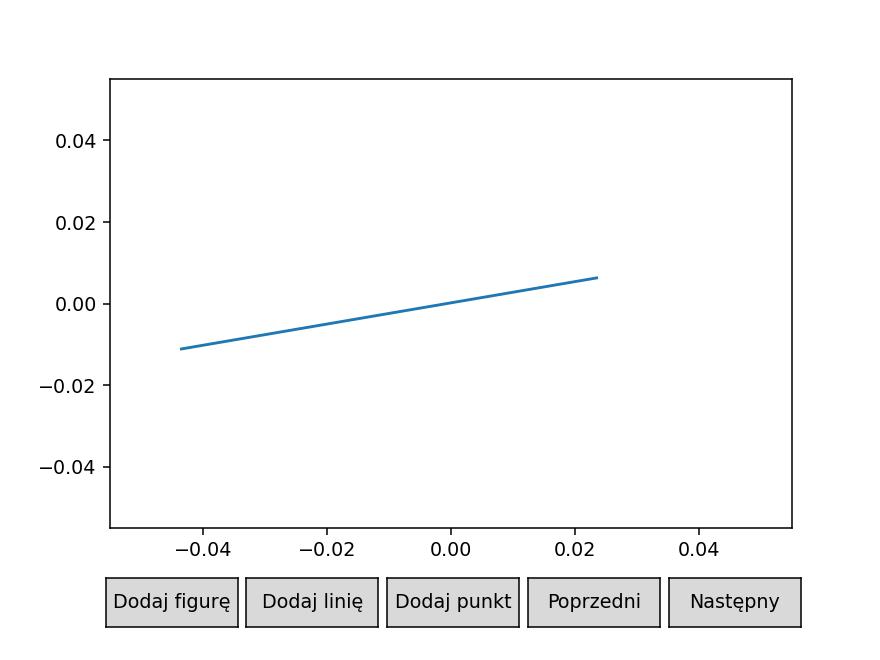

In [44]:
%matplotlib notebook

visualizer = Visualizer([])
plot2 = Plot()
plot2.draw()

In [45]:
lines2 = getLineObjects(getLineSegments(plot2))
print(lines2)

<IPython.core.display.Javascript object>


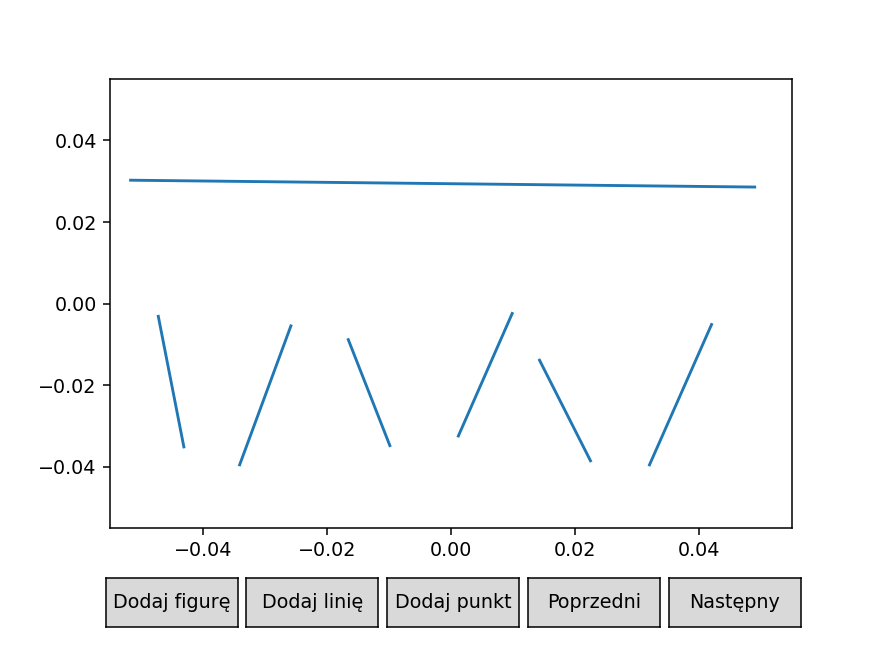

In [50]:
%matplotlib notebook

visualizer = Visualizer([])
plot3 = Plot()
plot3.draw()

In [51]:
lines3 = getLineObjects(getLineSegments(plot3))
print(lines3)

[<structures.Segment object at 0x0000023B608E81C0>, <structures.Segment object at 0x0000023B608E8370>, <structures.Segment object at 0x0000023B608E8EB0>, <structures.Segment object at 0x0000023B608E8E80>, <structures.Segment object at 0x0000023B608E86A0>, <structures.Segment object at 0x0000023B608E8F70>, <structures.Segment object at 0x0000023B608E8A60>]


<IPython.core.display.Javascript object>


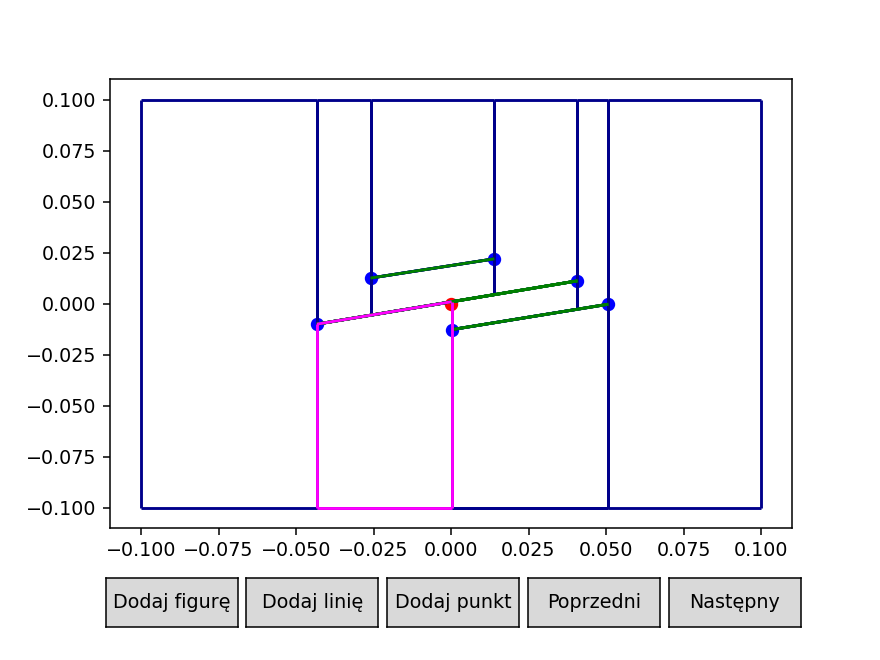

In [65]:
visualizer = Visualizer([])

dag = buildDag(lines1, visualizer)

test_point1 = Point(0, 0)
tr1 = findArea(dag.root, test_point1)
visualizer.addDagWithResult(dag, tr1, test_point1)

plot = Plot(visualizer.getScenes())
plot.draw()

<IPython.core.display.Javascript object>


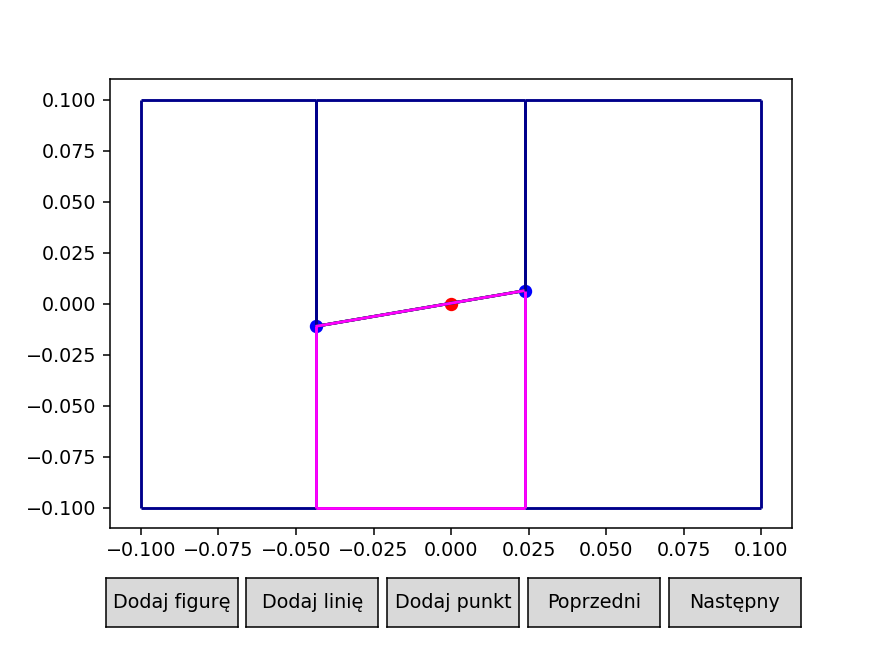

In [62]:
visualizer = Visualizer([])

dag = buildDag(lines2, visualizer)

test_point1 = Point(0, 0)
tr2 = findArea(dag.root, test_point1)
visualizer.addDagWithResult(dag, tr2, test_point1)

plot = Plot(visualizer.getScenes())
plot.draw()

<IPython.core.display.Javascript object>


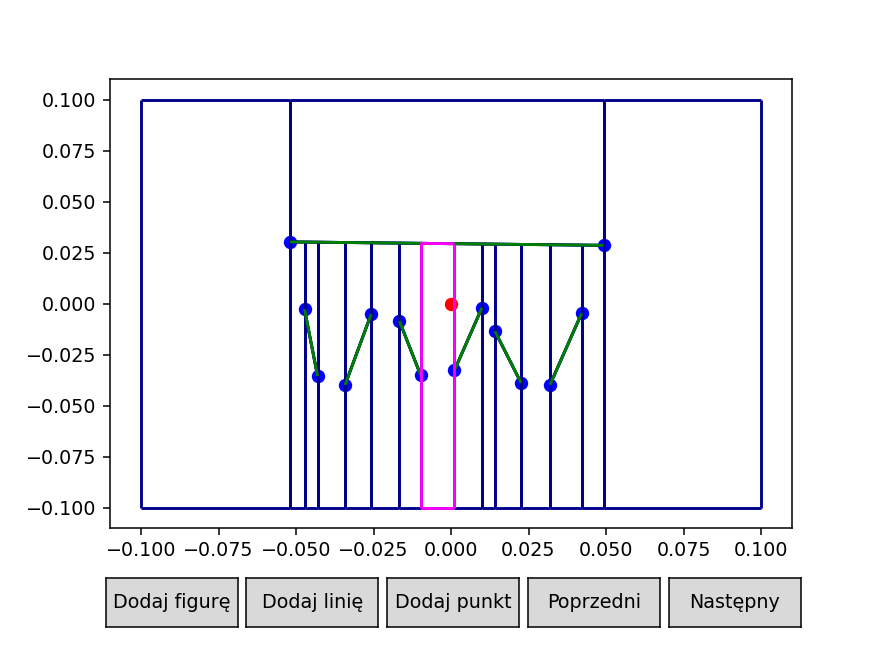

In [66]:
visualizer = Visualizer([])

dag = buildDag(lines3, visualizer)

test_point1 = Point(0, 0)
tr3 = findArea(dag.root, test_point1)
visualizer.addDagWithResult(dag, tr3, test_point1)

plot = Plot(visualizer.getScenes())
plot.draw()

## Czas działania algorytmu

In [154]:
start_time = time.time()
dag = buildDag(lines1, None)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
dag = buildDag(lines2, None)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
dag = buildDag(lines3, None)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---
--- 0.0 seconds ---
--- 0.0009696483612060547 seconds ---
